# Image Compression

The goal of this notebook is to explore image compression using various forms of matrix decomposition.

In [1]:
import numpy as np
from numpy import random
import math
from matplotlib import pyplot as plt
from scipy import misc
import scipy
from tqdm import tqdm, trange
from time import perf_counter

In [2]:
%cd ..
from rputil import *
%cd -

/mnt/c/Users/rishi/GitHub/icerm/random-projections
/mnt/c/Users/rishi/GitHub/icerm/random-projections/notebooks


## ID2, RID2

In [3]:
import scipy.linalg.interpolative as sli

def id2_rank_k(A, k):
    idx, proj = sli.interp_decomp(A, k, rand=False)
    B = sli.reconstruct_skel_matrix(A, k, idx)
    C = sli.reconstruct_matrix_from_id(B, idx, proj)
    return C

def rid2_rank_k(A, k):
    idx, proj = sli.interp_decomp(A, k, rand=True)
    B = sli.reconstruct_skel_matrix(A, k, idx)
    C = sli.reconstruct_matrix_from_id(B, idx, proj)
    return C

In [31]:
def rid3_rank_k(A, k):
    cols = np.random.choice(A.shape[1], replace=False, size=k)
    AS = A[:,cols]
    Q, R = scipy.linalg.qr(AS, pivoting=False, mode='economic')
    return Q @ Q.T @ A

## Calculating Statistics

Here, we vary the rank k of the approximation and analyze the quality of the resulting compressed images:

In [4]:
import pandas as pd
mnist = pd.read_csv('../datasets/mnist/train.csv')

data = mnist[mnist.columns[1:]].values / 255
data = data[:10000]

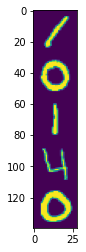

In [11]:
plt.imshow(data[:5].reshape(28*5,28))

In [12]:
data = data.T

In [13]:
data_norm = np.linalg.norm(data)

In [14]:
def calculate_error(A):
    return np.linalg.norm(data - A) / data_norm

In [15]:
def stats(A):
    res = np.empty(7)
    
    res[0] = np.quantile(A, 0.25)
    res[1] = np.median(A)
    res[2] = np.quantile(A, 0.75)
    res[3] = np.mean(A)
    res[4] = np.std(A)
    res[5] = np.min(A)
    res[6] = np.max(A)
    
    return np.copy(res)

In [16]:
k_domain = np.concatenate(([1, 2, 5, 10], np.arange(20, 400, step=40), [400, 420, 440]))
k_len = k_domain.shape[0]

### deterministic methods

In [24]:
error_svd = np.empty(k_len)
error_id = np.empty(k_len)
error_id2 = np.empty(k_len)

time_svd = np.empty(k_len)
time_id = np.empty(k_len)
time_id2 = np.empty(k_len)

for i,val in enumerate(tqdm(k_domain)):
    #SVD
    start = perf_counter()
    error_svd[i] = calculate_error(svd_rank_k(data, val))
    time_svd[i] = perf_counter() - start
    
    #ID
    start = perf_counter()
    error_id[i] = calculate_error(id_rank_k(data, val))
    time_id[i] = perf_counter() - start
    
    #ID2 (SciPy)
    start = perf_counter()
    error_id2[i] = calculate_error(id2_rank_k(data, val))
    time_id2[i] = perf_counter() - start

100%|██████████| 17/17 [06:42<00:00, 23.70s/it]


### randomized methods

In [32]:
stat_dims = (7, k_len)
error_random_svd = np.empty(stat_dims)
error_random_id = np.empty(stat_dims)
error_random_id2 = np.empty(stat_dims)
error_random_id3 = np.empty(stat_dims)

time_random_svd = np.empty(k_len)
time_random_id = np.empty(k_len)
time_random_id2 = np.empty(k_len)
time_random_id3 = np.empty(k_len)


iterations = 3 #10

for i,val in enumerate(tqdm(k_domain)):
    err_rsvd = np.empty(iterations)
    err_rid = np.empty(iterations)
    err_rid2 = np.empty(iterations)
    err_rid3 = np.empty(iterations)
    
    t_rsvd = np.empty(iterations)
    t_rid = np.empty(iterations)
    t_rid2 = np.empty(iterations)
    t_rid3 = np.empty(iterations)
    
    for j in range(iterations):
        #RSVD
        start = perf_counter()
        err_rsvd[j] = calculate_error(random_svd_rank_k(data,val))
        t_rsvd[j] = perf_counter() - start
        
        #RID
        start = perf_counter()
        err_rid[j] = calculate_error(random_id_rank_k(data,val))
        t_rid[j] = perf_counter() - start
        
        #RID2 (SciPy)
        start = perf_counter()
        err_rid2[j] = calculate_error(rid2_rank_k(data,val))
        t_rid2[j] = perf_counter() - start
        
        #RID3 (no oversampling + no pivoting)
        start = perf_counter()
        err_rid3[j] = calculate_error(rid3_rank_k(data,val))
        t_rid3[j] = perf_counter() - start
    
    error_random_svd[:,i] = stats(err_rsvd)
    error_random_id[:,i] = stats(err_rid)
    error_random_id2[:,i] = stats(err_rid2)
    error_random_id3[:,i] = stats(err_rid3)
    
    time_random_svd[i] = np.mean(t_rsvd)
    time_random_id[i] = np.mean(t_rid)
    time_random_id2[i] = np.mean(t_rid2)
    time_random_id3[i] = np.mean(t_rid3)

100%|██████████| 17/17 [09:21<00:00, 33.00s/it]


## Display results

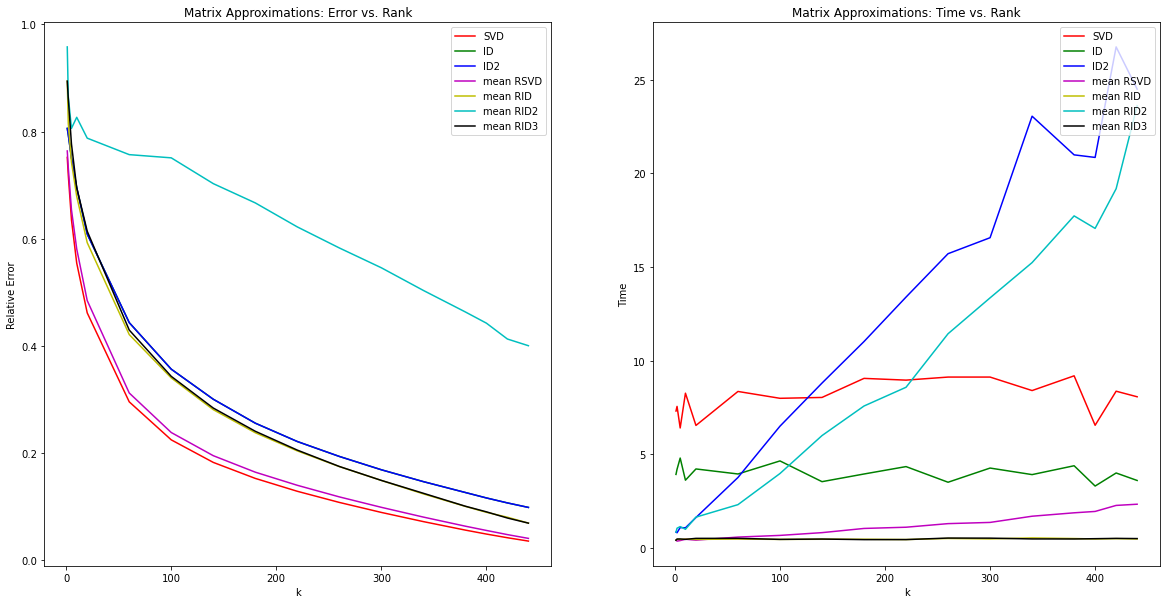

In [37]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].plot(k_domain, error_svd, c='r', label='SVD')
ax[0].plot(k_domain, error_id, c='g', label='ID')
ax[0].plot(k_domain, error_id2, c='b', label='ID2')
ax[0].plot(k_domain, error_random_svd[3], c='m', label='mean RSVD')
ax[0].plot(k_domain, error_random_id[3], c='y', label='mean RID')
ax[0].plot(k_domain, error_random_id2[3], c='c', label='mean RID2')
ax[0].plot(k_domain, error_random_id3[3], c='black', label='mean RID3')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
# ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Matrix Approximations: Error vs. Rank')

ax[1].plot(k_domain, time_svd, c='r', label='SVD')
ax[1].plot(k_domain, time_id, c='g', label='ID')
ax[1].plot(k_domain, time_id2, c='b', label='ID2')
ax[1].plot(k_domain, time_random_svd, c='m', label='mean RSVD')
ax[1].plot(k_domain, time_random_id, c='y', label='mean RID')
ax[1].plot(k_domain, time_random_id2, c='c', label='mean RID2')
ax[1].plot(k_domain, time_random_id3, c='black', label='mean RID3')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Time')
# ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Matrix Approximations: Time vs. Rank');

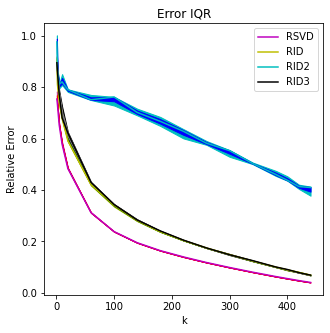

In [34]:
fig, ax = plt.subplots(1, figsize=(5,5))


ax.fill_between(k_domain, error_random_svd[5], error_random_svd[6], color='m')
ax.fill_between(k_domain, error_random_id[5], error_random_id[6], color='y')
ax.fill_between(k_domain, error_random_id2[5], error_random_id2[6], color='c')
ax.fill_between(k_domain, error_random_id3[5], error_random_id3[6], color='black')


ax.fill_between(k_domain, error_random_svd[0], error_random_svd[2], color='r')
ax.fill_between(k_domain, error_random_id[0], error_random_id[2], color='g')
ax.fill_between(k_domain, error_random_id2[0], error_random_id2[2], color='b')
ax.fill_between(k_domain, error_random_id3[0], error_random_id3[2], color='grey')


ax.plot(k_domain, error_random_svd[1], c='m', label='RSVD')
ax.plot(k_domain, error_random_id[1], c='y', label='RID')
ax.plot(k_domain, error_random_id2[1], c='c', label='RID2')
ax.plot(k_domain, error_random_id3[1], c='black', label='RID3')
ax.set_xlabel('k')
ax.set_ylabel('Relative Error')
ax.legend(loc='upper right')
ax.set_title('Error IQR');

In [35]:
error_id - error_id2

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.11022302e-16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -5.55111512e-17,
        0.00000000e+00,  0.00000000e+00, -5.55111512e-17,  2.77555756e-17,
        0.00000000e+00,  0.00000000e+00, -1.38777878e-17,  0.00000000e+00,
        0.00000000e+00])